In [1]:
import pandas as pd
import numpy as np
import time

from xgboost import XGBRegressor

np.random.seed(2019)

## Data preparation

In [2]:
train = pd.read_hdf('../input/train_airline_delay.h5')
test = pd.read_csv('../input/test_airline_delay.csv')
airports_timezones = pd.read_csv('../input/timezones_iata.csv')

In [3]:
##########################################################################
#
# Categorize function
#

def categorize_feature(df, feat, feat_cat, indexers, del_feat=True, unknown_cat_name='unknown', unknown_cat_val=-1):
    if feat in indexers:
        return categorize_feature_for_test(df, feat, feat_cat, indexers[feat], del_feat=del_feat, unknown_cat_name=unknown_cat_name, unknown_cat_val=unknown_cat_val)
    
    categories_map = categorize_feature_for_train(df, feat, feat_cat, indexers, del_feat=del_feat, unknown_cat_name=unknown_cat_name)
    
def categorize_feature_for_test(df, feat, feat_cat, categories_map, del_feat=True, unknown_cat_name='unknown', unknown_cat_val=-1):
    df[feat_cat] = [categories_map[x] if x in categories_map 
                    else categories_map[unknown_cat_name] if unknown_cat_name in categories_map 
                    else unknown_cat_val for x in df[feat]]
    
    if del_feat:
        del df[feat]
    
def categorize_feature_for_train(df, feat, feat_cat, indexers, del_feat=True, unknown_cat_name='unknown'):
    df.loc[df[feat].isnull(), feat] = unknown_cat_name

    unique_categories = sorted(list(set(df[feat])),key=str)
    
    categories_map = {}

    for i, (cat) in enumerate(unique_categories):
        categories_map[cat] = i

    for cat, ind in categories_map.items():
        df.loc[df[feat] == cat, feat_cat] = ind

    indexers[feat] = categories_map
    
    if del_feat:
        del df[feat]
        
##########################################################################
#
# Data preparation
#

def perform_engineering(df, train_indexers=None):
    indexers = train_indexers if train_indexers != None else {}
    
    df['scheduled_departure_time'] = df['scheduled_departure_time'].map(lambda x: int(x))
    df['scheduled_arrival_time'] = df['scheduled_arrival_time'].map(lambda x: int(x))
    df['scheduled_elapsed_time'] = df['scheduled_elapsed_time'].map(lambda x: int(x))
    df['zone_id'] = df['zone_id'].map(lambda x: int(x))
    
    #
    # categorization
    #
    categorize_feature(df, 'origin', 'origin_cat', indexers=indexers)
    categorize_feature(df, 'destination', 'destination_cat', indexers=indexers)
    
    #
    # pairs
    #
    df['airport_pair'] = df.apply(lambda x: x['origin_cat']*10000 + x['destination_cat'], axis=1)
    df['tail_carrier_pair'] = df.apply(lambda x: x['tail_number']*1000 + x['carrier_id'], axis=1)
    df['tail_year_pair'] = df.apply(lambda x: x['tail_number']*10 + x['year'], axis=1)
    df['month_year_pair'] = df.apply(lambda x: x['month']*10 + x['year'], axis=1)
    df['month_day_pair'] = df.apply(lambda x: x['month']*100 + x['day_of_month'], axis=1)
    df['tail_destination_cat_pair'] = df.apply(lambda x: x['tail_number']*1000 + x['destination_cat'], axis=1)
    
    #
    # cleanup
    #
    columns_to_remove = ['scheduled_duration', 'actual_departure_time', 'actual_arrival_time',
                        'is_cancelled', 'actual_elapsed_time', 'air_time', 'departure_delay', 'arrival_delay', 
                        'cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 
                         'late_aircraft_delay', 'is_diverted'  ]
    for col_to_remove in columns_to_remove:
        if col_to_remove in df: del df[col_to_remove]
    
    return df, indexers


#############################################################################

airports_timezones['zones_num']=airports_timezones['tz'].factorize()[0]

unique_categories = sorted(list(set(train['origin'])),key=str)

for airport in unique_categories:
    train.loc[train['origin'] == airport, 'zone_id'] = airports_timezones['zones_num'][airports_timezones['code'] == airport].values[0]
    test.loc[test['origin'] == airport, 'zone_id'] = airports_timezones['zones_num'][airports_timezones['code'] == airport].values[0]

## fill NA
train = train.fillna(-1)
test = test.fillna(-1)

## prepare data in train and test sets
%time train, indexers = perform_engineering(train)
%time test, dummy = perform_engineering(test, indexers)
  

CPU times: user 7min 40s, sys: 10.1 s, total: 7min 50s
Wall time: 3min 54s
CPU times: user 2min 24s, sys: 1.89 s, total: 2min 25s
Wall time: 2min 18s


In [4]:
###########################################################################
#
# PREPARE FEATURES
#

black_list = ['target_delay', 'id', 'is_cancelled']

bool_features = train.select_dtypes(include=[np.bool]).columns.values.tolist()
cat_feats = [feat for feat in train.columns if 'cat' in feat]

numeric_features = train.select_dtypes(include=[np.float64, np.int64, np.int16, np.int8]).columns.values
numeric_features = [feat for feat in numeric_features if feat not in (black_list + cat_feats) ]

feats = bool_features + numeric_features + cat_feats 
feats = [feat for feat in feats if feat not in (black_list)]

#
# prepare train dataset
#

X = train[ feats ].values
y = train[ 'target_delay' ].values
y_log = np.log1p(y)

print("Selected features: ", feats)

Selected features:  ['year', 'month', 'day_of_month', 'day_of_week', 'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id', 'flight_number', 'tail_number', 'scheduled_elapsed_time', 'distance', 'zone_id', 'airport_pair', 'tail_carrier_pair', 'tail_year_pair', 'month_year_pair', 'month_day_pair', 'origin_cat', 'destination_cat', 'tail_destination_cat_pair']


## Model

In [5]:
xgb_params = {
    'n_jobs': 4, 
    'max_depth': 14, 
    'n_estimators': 120, 
    'learning_rate': 0.1, 
    'min_child_weight': 8, 
    'random_state': 2019
}

#
# fit model
#

model = XGBRegressor(**xgb_params)
%time model.fit(X, y_log)

CPU times: user 29min 50s, sys: 6.49 s, total: 29min 56s
Wall time: 7min 29s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=8, missing=None, n_estimators=120, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=2019,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [6]:
#
# test data predictions
#

X = test[feats].values

y_log_pred = model.predict(X)
y_pred = np.expm1( y_log_pred )

In [7]:
#
# Additional operations
#

test['target_delay'] = y_pred
test['target_delay'] = test['target_delay'].map(lambda x: x if x<350 else 4320)

## Submission preparation

In [8]:

test[ ['id', 'target_delay'] ].to_csv('../output/' + time.strftime("%Y%m%d_%H%M%S") + '.csv', index=False) 


## Feature importances

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

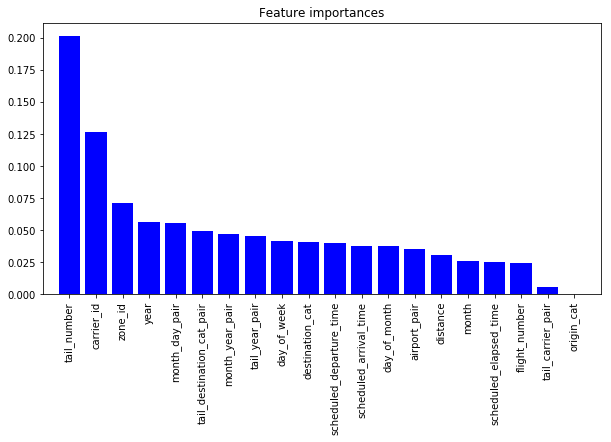

In [10]:
draw_feature_importances(model, feats)